In [103]:
# Importing standard libraries

import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns

from sklearn import preprocessing
import sklearn
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer
from matplotlib import pyplot as plt


# Reading data and preprocessing

In [104]:
import os 
os.getcwd()
os.listdir(os.getcwd())

['OnlineRetail.csv', 'Online Retail Project.ipynb']

In [105]:
# Encoding - file is encoded in 'ISO-8859-1' (also known as 'Latin-1')
df = pd.read_csv('OnlineRetail.csv', encoding='latin-1')

In [106]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [107]:
df.shape


(541909, 8)

In [108]:
#Removing duplicate entries 
print('Duplicate entries: {}'.format(df.duplicated().sum()))
print('{}% rows are duplicate.'.format(round((df.duplicated().sum()/df.shape[0])*100),2))
df.drop_duplicates(inplace = True)


Duplicate entries: 5268
1% rows are duplicate.


In [109]:
df.shape

(536641, 8)

In [110]:
#Checking the total number of products, transactions and customers.

pd.DataFrame([{'Products': len(df['StockCode'].value_counts()),    
               'Transactions': len(df['InvoiceNo'].value_counts()),
               'Customers': len(df['CustomerID'].value_counts()),  
              }], columns = ['Products', 'Transactions', 'Customers'], index = ['Quantity'])


,Products,Transactions,Customers
Quantity,3999,31847,4370


Checking country wise distribution of transactions.

In [111]:

temp = df.groupby(['Country'],as_index=False).agg({'InvoiceNo':'nunique'}).rename(columns = {'InvoiceNo':'Orders'})
total = temp['Orders'].sum(axis=0)
temp['%Orders'] = round((temp['Orders']/total)*100,4)


In [112]:
print(temp)

                 Country  Orders  %Orders
0              Australia      69   0.2668
1                Austria      19   0.0735
2                Bahrain       4   0.0155
3                Belgium     119   0.4602
4                 Brazil       1   0.0039
5                 Canada       6   0.0232
6        Channel Islands      32   0.1238
7                 Cyprus      20   0.0773
8         Czech Republic       5   0.0193
9                Denmark      21   0.0812
10                  EIRE     360   1.3922
11    European Community       5   0.0193
12               Finland      47   0.1818
13                France     461   1.7828
14               Germany     603   2.3320
15                Greece       6   0.0232
16             Hong Kong      15   0.0580
17               Iceland       7   0.0271
18                Israel       9   0.0348
19                 Italy      55   0.2127
20                 Japan      28   0.1083
21               Lebanon       1   0.0039
22             Lithuania       4  

In [113]:
temp.sort_values(by=['%Orders'],ascending=False,inplace=True)
temp.reset_index(drop=True,inplace=True)


Text(0, 0.5, '%Orders')

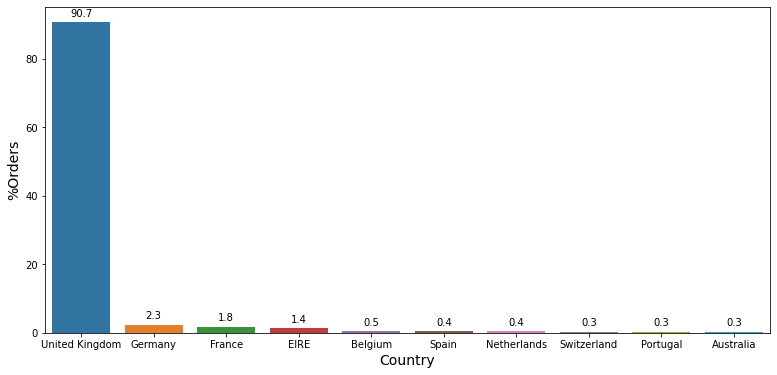

In [114]:
plt.figure(figsize=(13,6))
splot=sns.barplot(x="Country",y="%Orders",data=temp[:10])
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xlabel("Country", size=14)
plt.ylabel("%Orders", size=14)


Removing cancelled orders from the data.

In [115]:
invoices = df['InvoiceNo']

x = invoices.str.contains('C', regex=True)
x.fillna(0, inplace=True)
x = x.astype(int)
x.value_counts()
df['order_canceled'] = x
df.tail()
#df[df['order_canceled'] == 1]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,order_canceled
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12.0,12/9/2011 12:50,0.85,12680.0,France,0
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6.0,12/9/2011 12:50,2.10,12680.0,France,0
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4.0,12/9/2011 12:50,4.15,12680.0,France,0
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4.0,12/9/2011 12:50,4.15,12680.0,France,0
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3.0,12/9/2011 12:50,4.95,12680.0,France,0


In [116]:
df['order_canceled'].value_counts()

n1 = df['order_canceled'].value_counts()[1]
n2 = df.shape[0]
print('Number of orders canceled: {}/{} ({:.2f}%) '.format(n1, n2, n1/n2*100))


Number of orders canceled: 12714/536641 (2.37%) 


In [117]:
df['order_canceled'].value_counts()


0    523927
1     12714
Name: order_canceled, dtype: int64

In [118]:
df = df.loc[df['order_canceled'] == 0,:]

df.reset_index(drop=True,inplace=True)


In [119]:
#Checking if we have negative quantities against any InvoiceNo.
df.loc[df['Quantity'] < 0,:]


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,order_canceled
2317,536589,21777,NaN,-10.0,12/1/2010 16:50,0.0,NaN,United Kingdom,0
4214,536764,84952C,NaN,-38.0,12/2/2010 14:42,0.0,NaN,United Kingdom,0
6944,536996,22712,NaN,-20.0,12/3/2010 15:30,0.0,NaN,United Kingdom,0
6945,536997,22028,NaN,-20.0,12/3/2010 15:30,0.0,NaN,United Kingdom,0
6946,536998,85067,NaN,-6.0,12/3/2010 15:30,0.0,NaN,United Kingdom,0
...,...,...,...,...,...,...,...,...,...
517508,581210,23395,check,-26.0,12/7/2011 18:36,0.0,NaN,United Kingdom,0
517510,581212,22578,lost,-1050.0,12/7/2011 18:38,0.0,NaN,United Kingdom,0
517511,581213,22576,check,-30.0,12/7/2011 18:38,0.0,NaN,United Kingdom,0
519074,581226,23090,missing,-338.0,12/8/2011 9:56,0.0,NaN,United Kingdom,0


In [120]:
#We find out that CustomerID values are missing for those customers which have negative quantity values. Therefore, we will remove them too.
df = df[df['CustomerID'].notna()]

df.reset_index(drop=True,inplace=True)
df_uk = df[df.Country == 'United Kingdom']
df_uk.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,order_canceled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,12/1/2010 8:26,2.55,17850.0,United Kingdom,0
1,536365,71053,WHITE METAL LANTERN,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,12/1/2010 8:26,2.75,17850.0,United Kingdom,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom,0


In [121]:
df_uk.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 345957 entries, 0 to 389180
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   InvoiceNo       345957 non-null  object 
 1   StockCode       345957 non-null  object 
 2   Description     345957 non-null  object 
 3   Quantity        345957 non-null  float64
 4   InvoiceDate     345957 non-null  object 
 5   UnitPrice       345957 non-null  float64
 6   CustomerID      345957 non-null  float64
 7   Country         345957 non-null  object 
 8   order_canceled  345957 non-null  int64  
dtypes: float64(3), int64(1), object(5)
memory usage: 26.4+ MB


In [122]:
pd.DataFrame([{'Products': len(df['StockCode'].value_counts()),    
               'Transactions': len(df['InvoiceNo'].value_counts()),
               'Customers': len(df['CustomerID'].value_counts()),  
              }], columns = ['Products', 'Transactions', 'Customers'], index = ['Quantity'])


,Products,Transactions,Customers
Quantity,3584,18525,4337


# Cohort Analysis

In [123]:
cohort_data = df_uk[['InvoiceNo','StockCode','Description','Quantity','InvoiceDate','UnitPrice','CustomerID','Country']]


In [124]:
# Checking for nulls in the data.
cohort_data.isnull().sum()


InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [125]:
all_dates = (pd.to_datetime(cohort_data['InvoiceDate'])).apply(lambda x:x.date())


In [126]:
#Let us check the date range of our data.
print((all_dates.max() - all_dates.min()).days)

# Start and end dates:
print('Start date: {}'.format(all_dates.min()))
print('End date: {}'.format(all_dates.max()))


373
Start date: 2010-12-01
End date: 2011-12-09


In [127]:
cohort_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [128]:

def get_month(x):
    return dt.datetime(x.year, x.month, 1)

cohort_data.loc[:, 'InvoiceDate'] = pd.to_datetime(cohort_data['InvoiceDate'])
cohort_data.loc[:,'InvoiceMonth'] = cohort_data['InvoiceDate'].apply(get_month)

grouping = cohort_data.groupby('CustomerID')['InvoiceMonth']
cohort_data['CohortMonth'] = grouping.transform('min') #month of customer's first purchase 
cohort_data.head()


/var/folders/f2/7t7dy3815cxcyl6h2wq6k6380000gn/T/ipykernel_755/625986842.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cohort_data.loc[:, 'InvoiceDate'] = pd.to_datetime(cohort_data['InvoiceDate'])


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01


In [129]:
def get_date_int(df, column):    
    year = df[column].dt.year    
    month = df[column].dt.month    
    day = df[column].dt.day
    return year, month, day


In [130]:
invoice_year, invoice_month, _ = get_date_int(cohort_data, 'InvoiceMonth') 
cohort_year, cohort_month, _ = get_date_int(cohort_data, 'CohortMonth')
years_diff = invoice_year - cohort_year
months_diff = invoice_month - cohort_month
cohort_data['CohortIndex'] = years_diff * 12 + months_diff
#CohortIndex : number of months that have passed since each customer's first purchase 
cohort_data.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010-12-01,0
1,536365,71053,WHITE METAL LANTERN,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,2010-12-01,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,0


In [131]:
cohort_data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010-12-01,0
1,536365,71053,WHITE METAL LANTERN,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,2010-12-01,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,0
...,...,...,...,...,...,...,...,...,...,...,...
389176,581585,22466,FAIRY TALE COTTAGE NIGHT LIGHT,12.0,2011-12-09 12:31:00,1.95,15804.0,United Kingdom,2011-12-01,2011-05-01,7
389177,581586,22061,LARGE CAKE STAND HANGING STRAWBERY,8.0,2011-12-09 12:49:00,2.95,13113.0,United Kingdom,2011-12-01,2010-12-01,12
389178,581586,23275,SET OF 3 HANGING OWLS OLLIE BEAK,24.0,2011-12-09 12:49:00,1.25,13113.0,United Kingdom,2011-12-01,2010-12-01,12
389179,581586,21217,RED RETROSPOT ROUND CAKE TINS,24.0,2011-12-09 12:49:00,8.95,13113.0,United Kingdom,2011-12-01,2010-12-01,12


In [132]:
grouping = cohort_data.groupby(['CohortMonth', 'CohortIndex'])  
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique)
cohort_data

CohortMonth  CohortIndex
2010-12-01   0              814
             1              289
             2              263
             3              304
             4              293
                           ... 
2011-10-01   1               79
             2               36
2011-11-01   0              298
             1               35
2011-12-01   0               34
Name: CustomerID, Length: 91, dtype: int64

In [133]:
cohort_data = cohort_data.reset_index()
cohort_data

,CohortMonth,CohortIndex,CustomerID
0,2010-12-01,0,814
1,2010-12-01,1,289
2,2010-12-01,2,263
3,2010-12-01,3,304
4,2010-12-01,4,293
...,...,...,...
86,2011-10-01,1,79
87,2011-10-01,2,36
88,2011-11-01,0,298
89,2011-11-01,1,35


In [134]:
##grouping = cohort_data.groupby(['CohortMonth', 'CohortIndex'])
##cohort_data = grouping['CustomerID'].apply(pd.Series.nunique)

#counts the number of unique customers for each combination of CohortMonth and CohortIndex 
##cohort_data = cohort_data.reset_index()

cohort_counts = cohort_data.pivot(index='CohortMonth',columns='CohortIndex',values='CustomerID')
# values in each cell represent the count of unique customers who made purchases in that combination of CohortMonth and CohortIndex.
cohort_counts

CohortIndex,0,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,,
2010-12-01,814.0,289.0,263.0,304.0,293.0,323.0,291.0,278.0,288.0,325.0,299.0,405.0,218.0
2011-01-01,358.0,76.0,93.0,84.0,119.0,99.0,90.0,87.0,108.0,117.0,127.0,43.0,NaN
2011-02-01,340.0,64.0,66.0,97.0,98.0,86.0,87.0,96.0,90.0,104.0,25.0,NaN,NaN
2011-03-01,418.0,64.0,109.0,83.0,94.0,69.0,110.0,96.0,119.0,37.0,NaN,NaN,NaN
2011-04-01,277.0,58.0,56.0,60.0,56.0,61.0,61.0,73.0,20.0,NaN,NaN,NaN,NaN
2011-05-01,256.0,48.0,44.0,44.0,53.0,58.0,68.0,22.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,214.0,38.0,31.0,51.0,51.0,69.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,169.0,30.0,33.0,39.0,47.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,141.0,32.0,32.0,34.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [135]:
cohort_sizes = cohort_counts.iloc[:,0]

In [136]:
cohort_sizes

CohortMonth
2010-12-01    814.0
2011-01-01    358.0
2011-02-01    340.0
2011-03-01    418.0
2011-04-01    277.0
2011-05-01    256.0
2011-06-01    214.0
2011-07-01    169.0
2011-08-01    141.0
2011-09-01    276.0
2011-10-01    324.0
2011-11-01    298.0
2011-12-01     34.0
Name: 0, dtype: float64

In [137]:
# Divide all values in the cohort_counts table by cohort_sizes
retention = cohort_counts.divide(cohort_sizes, axis=0) #row

# Review the retention table
retention.round(3) * 100
retention

#The first month's retention rate is 100%. This is because the number of active customers in the first month is actually the size of the cohort.


CohortIndex,0,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,,
2010-12-01,1.0,0.355037,0.323096,0.373464,0.359951,0.396806,0.357494,0.341523,0.353808,0.399263,0.367322,0.497543,0.267813
2011-01-01,1.0,0.212291,0.259777,0.234637,0.332402,0.276536,0.251397,0.243017,0.301676,0.326816,0.354749,0.120112,NaN
2011-02-01,1.0,0.188235,0.194118,0.285294,0.288235,0.252941,0.255882,0.282353,0.264706,0.305882,0.073529,NaN,NaN
2011-03-01,1.0,0.153110,0.260766,0.198565,0.224880,0.165072,0.263158,0.229665,0.284689,0.088517,NaN,NaN,NaN
2011-04-01,1.0,0.209386,0.202166,0.216606,0.202166,0.220217,0.220217,0.263538,0.072202,NaN,NaN,NaN,NaN
2011-05-01,1.0,0.187500,0.171875,0.171875,0.207031,0.226562,0.265625,0.085938,NaN,NaN,NaN,NaN,NaN
2011-06-01,1.0,0.177570,0.144860,0.238318,0.238318,0.322430,0.098131,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,1.0,0.177515,0.195266,0.230769,0.278107,0.106509,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,1.0,0.226950,0.226950,0.241135,0.120567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [138]:
cohort_data

,CohortMonth,CohortIndex,CustomerID
0,2010-12-01,0,814
1,2010-12-01,1,289
2,2010-12-01,2,263
3,2010-12-01,3,304
4,2010-12-01,4,293
...,...,...,...
86,2011-10-01,1,79
87,2011-10-01,2,36
88,2011-11-01,0,298
89,2011-11-01,1,35


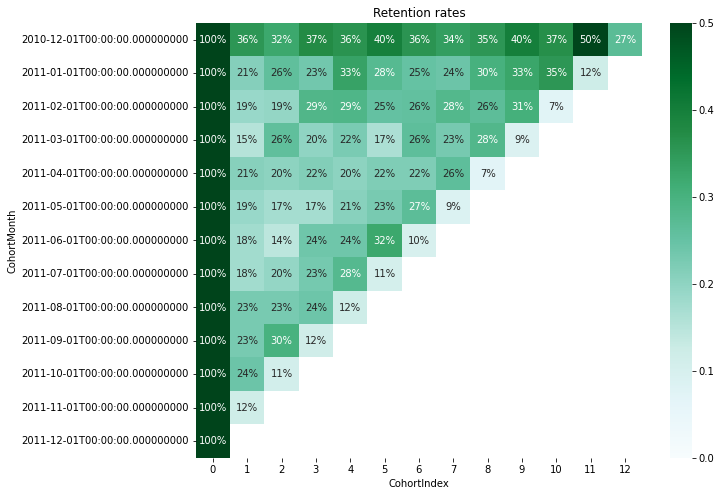

In [141]:
#Let us now visualize the retention rates by a heatmap.


plt.figure(figsize=(10, 8))
plt.title('Retention rates')
sns.heatmap(data=retention, annot=True, fmt='.0%', vmin=0.0, vmax=0.5, cmap='BuGn')
plt.show()




# RFM Segmentation

In [142]:
new_cohort_data = df_uk[['InvoiceNo','StockCode','Description','Quantity','InvoiceDate','UnitPrice','CustomerID','Country']]

new_cohort_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [143]:
new_cohort_data['TotalSum'] = new_cohort_data['Quantity']*new_cohort_data['UnitPrice']
new_cohort_data.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSum
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34


<AxesSubplot:>

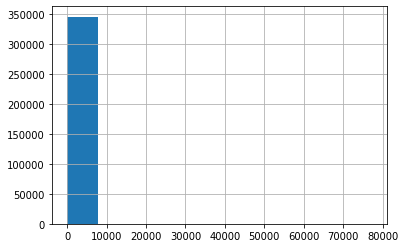

In [144]:
new_cohort_data.TotalSum.hist(bins=10)


In [145]:
new_cohort_data[['TotalSum']].describe()


,TotalSum
count,345957.000000
mean,20.442417
std,163.833392
min,0.000000
25%,4.200000
50%,10.400000
75%,17.850000
max,77183.600000


In [146]:
new_cohort_data[new_cohort_data['TotalSum']> 17.85].sort_values('TotalSum',ascending=False)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSum
36109,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215.0,1/18/2011 10:01,1.04,12346.0,United Kingdom,77183.60
151905,556444,22502,PICNIC BASKET WICKER 60 PIECES,60.0,6/10/2011 15:28,649.50,15098.0,United Kingdom,38970.00
115556,551697,POST,POSTAGE,1.0,5/3/2011 13:46,8142.75,16029.0,United Kingdom,8142.75
243572,567423,23243,SET OF TEA COFFEE SUGAR TINS PANTRY,1412.0,9/20/2011 11:05,5.06,17450.0,United Kingdom,7144.72
107000,550461,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114.0,4/18/2011 13:20,2.10,15749.0,United Kingdom,6539.40
...,...,...,...,...,...,...,...,...,...
77930,546769,84459A,PINK METAL CHICKEN HEART,12.0,3/16/2011 14:57,1.49,17504.0,United Kingdom,17.88
210376,563619,37448,CERAMIC CAKE DESIGN SPOTTED MUG,12.0,8/18/2011 10:01,1.49,12839.0,United Kingdom,17.88
77929,546769,84459B,YELLOW METAL CHICKEN HEART,12.0,3/16/2011 14:57,1.49,17504.0,United Kingdom,17.88
77896,546764,22558,CLOTHES PEGS RETROSPOT PACK 24,12.0,3/16/2011 14:31,1.49,15671.0,United Kingdom,17.88


Let us check the start and End date.

In [147]:
from dateutil.relativedelta import relativedelta


In [148]:
new_all_dates = (pd.to_datetime(new_cohort_data['InvoiceDate'])).apply(lambda x:x.date())

new_start_date = new_all_dates.max()-relativedelta(months=12,days=-1)
print('Start date: {}'.format(new_start_date))
print('End date: {}'.format(new_all_dates.max()))


Start date: 2010-12-10
End date: 2011-12-09


In [149]:
new_cohort_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSum
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,12/1/2010 8:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,12/1/2010 8:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom,20.34


In [150]:
new_cohort_data[new_cohort_data['TotalSum']> 17.85].sort_values('TotalSum',ascending=False)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSum
36109,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215.0,1/18/2011 10:01,1.04,12346.0,United Kingdom,77183.60
151905,556444,22502,PICNIC BASKET WICKER 60 PIECES,60.0,6/10/2011 15:28,649.50,15098.0,United Kingdom,38970.00
115556,551697,POST,POSTAGE,1.0,5/3/2011 13:46,8142.75,16029.0,United Kingdom,8142.75
243572,567423,23243,SET OF TEA COFFEE SUGAR TINS PANTRY,1412.0,9/20/2011 11:05,5.06,17450.0,United Kingdom,7144.72
107000,550461,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114.0,4/18/2011 13:20,2.10,15749.0,United Kingdom,6539.40
...,...,...,...,...,...,...,...,...,...
77930,546769,84459A,PINK METAL CHICKEN HEART,12.0,3/16/2011 14:57,1.49,17504.0,United Kingdom,17.88
210376,563619,37448,CERAMIC CAKE DESIGN SPOTTED MUG,12.0,8/18/2011 10:01,1.49,12839.0,United Kingdom,17.88
77929,546769,84459B,YELLOW METAL CHICKEN HEART,12.0,3/16/2011 14:57,1.49,17504.0,United Kingdom,17.88
77896,546764,22558,CLOTHES PEGS RETROSPOT PACK 24,12.0,3/16/2011 14:31,1.49,15671.0,United Kingdom,17.88


In [151]:
new_cohort_data['InvoiceDate'].dtypes

dtype('O')

In [152]:
#data_rfm = new_cohort_data[new_cohort_data['InvoiceDate'] >= pd.to_datetime(new_start_date)] # convert string to Timestamp

data_rfm = new_cohort_data[pd.to_datetime(new_cohort_data['InvoiceDate']) >= pd.to_datetime(new_start_date)] # convert string to Timestamp

data_rfm.reset_index(drop=True,inplace=True)
data_rfm.head()
#data_rfm.shape

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSum
0,538172,21562,HAWAIIAN GRASS SKIRT,12.0,12/10/2010 9:33,1.25,15805.0,United Kingdom,15.0
1,538172,79321,CHILLI LIGHTS,8.0,12/10/2010 9:33,4.95,15805.0,United Kingdom,39.6
2,538172,84558A,3D DOG PICTURE PLAYING CARDS,12.0,12/10/2010 9:33,2.95,15805.0,United Kingdom,35.4
3,538172,22952,60 CAKE CASES VINTAGE CHRISTMAS,24.0,12/10/2010 9:33,0.55,15805.0,United Kingdom,13.2
4,538172,22910,PAPER CHAIN KIT VINTAGE CHRISTMAS,24.0,12/10/2010 9:33,2.95,15805.0,United Kingdom,70.8


In [153]:
snapshot_date = max(pd.to_datetime(data_rfm.InvoiceDate)) + dt.timedelta(days=1)   # convert the string to a datetime object 
print('Snapshot date: {}'.format(snapshot_date.date()))


Snapshot date: 2011-12-10


The dt.timedelta() function is used to add one day to the maximum date, which is stored in the snapshot_date variable.

The purpose of this is to create a reference point for calculating recency in the RFM analysis. The snapshot date represents the most recent point in time when the analysis was conducted. Any purchases made before the snapshot date are considered "historical" and any purchases made after the snapshot date are considered "current".

In [155]:
# Aggregate data on a customer level
data = data_rfm.groupby(['CustomerID'],as_index=False).agg({'InvoiceDate': lambda x: (snapshot_date - pd.to_datetime(x).max()).days,
                                             'InvoiceNo': 'count',
                                             'TotalSum': 'sum'}).rename(columns = {'InvoiceDate': 'Recency',
                                                                                   'InvoiceNo': 'Frequency',
                                                                                   'TotalSum': 'MonetaryValue'})
#InvoiceNo - nunique or count ? 
# number of days between the snapshot_date (a predefined variable) and the maximum invoice date
data.head() 


,CustomerID,Recency,Frequency,MonetaryValue
0,12346.0,326,1,77183.60
1,12747.0,2,96,3837.45
2,12748.0,1,4018,30725.81
3,12749.0,4,197,4045.58
4,12820.0,3,59,942.34


In [156]:
r_labels = range(4, 0, -1)
f_labels = range(1,5)
m_labels = range(1,5)

#uses pd.qcut to divide the Recency, Frequency, MonetaryValue data into four equal quantiles and assigns the corresponding label for each quantile
r_quartiles = pd.qcut(data['Recency'], 4, labels = r_labels)
f_quartiles = pd.qcut(data['Frequency'], 4, labels = f_labels)
m_quartiles = pd.qcut(data['MonetaryValue'], 4, labels = m_labels)

data = data.assign(R = r_quartiles.values)
data = data.assign(F = f_quartiles.values)
data = data.assign(M = m_quartiles.values)

data.head()


,CustomerID,Recency,Frequency,MonetaryValue,R,F,M
0,12346.0,326,1,77183.60,1,1,4
1,12747.0,2,96,3837.45,4,4,4
2,12748.0,1,4018,30725.81,4,4,4
3,12749.0,4,197,4045.58,4,4,4
4,12820.0,3,59,942.34,4,3,3


In [157]:
def join_rfm(x):
    return str(x['R']) + str(x['F']) + str(x['M'])

#creates a new column that contains the concatenated RFM values for each customer
data['RFM_Segment'] = data.apply(join_rfm, axis=1)
#creates a new column that contains the total RFM score for each customer
data['RFM_Score'] = data[['R','F','M']].sum(axis=1)
data.head()


,CustomerID,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score
0,12346.0,326,1,77183.60,1,1,4,1.01.04.0,6
1,12747.0,2,96,3837.45,4,4,4,4.04.04.0,12
2,12748.0,1,4018,30725.81,4,4,4,4.04.04.0,12
3,12749.0,4,197,4045.58,4,4,4,4.04.04.0,12
4,12820.0,3,59,942.34,4,3,3,4.03.03.0,10


In [158]:
data.groupby('RFM_Score').agg({'Recency': 'mean',
                                   'Frequency': 'mean',
                                   'MonetaryValue': ['mean', 'count'] }).round(1)

#count for MonetaryValue represents the number of customers who fall into each RFM score group 

Recency Frequency MonetaryValue      
             mean      mean          mean count
RFM_Score                                      
3           242.9       7.8         148.5   326
4           170.7      13.5         222.9   355
5           146.6      19.6         348.2   452
6            88.9      27.0         820.0   433
7            80.5      38.5         696.9   392
8            56.6      51.9         921.0   405
9            44.1      73.1        1310.4   369
10           31.9     109.3        1847.0   388
11           20.8     181.8        3429.3   334
12            6.9     347.4        7912.7   400

In [159]:
def create_segment(df):
    if df['RFM_Score'] >= 9:
        return 'Top'
    elif (df['RFM_Score'] >= 5) and (df['RFM_Score'] < 9):
        return 'Middle'
    else:
        return 'Low'
    
data['General_Segment'] = data.apply(create_segment, axis=1)
data.groupby('General_Segment').agg({'Recency': 'mean',
                                         'Frequency': 'mean',
                                         'MonetaryValue': ['mean', 'count']}).round(1)


Recency Frequency MonetaryValue      
                   mean      mean          mean count
General_Segment                                      
Low               205.3      10.8         187.3   681
Middle             94.7      33.7         688.8  1682
Top                25.7     180.5        3695.9  1491

Preprocessing data for Clustering
In the next section, we are going to prepare the data for Kmeans clustering on RFM Score data. To do this, we need to preprocess the data so that it can meet the key assumptions of Kmeans algorithm, which are:

The varaiables should be distributed symmetrically
Variables should have similar average values
Variables should have similar standard deviation values


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt 

<AxesSubplot:xlabel='MonetaryValue', ylabel='Density'>

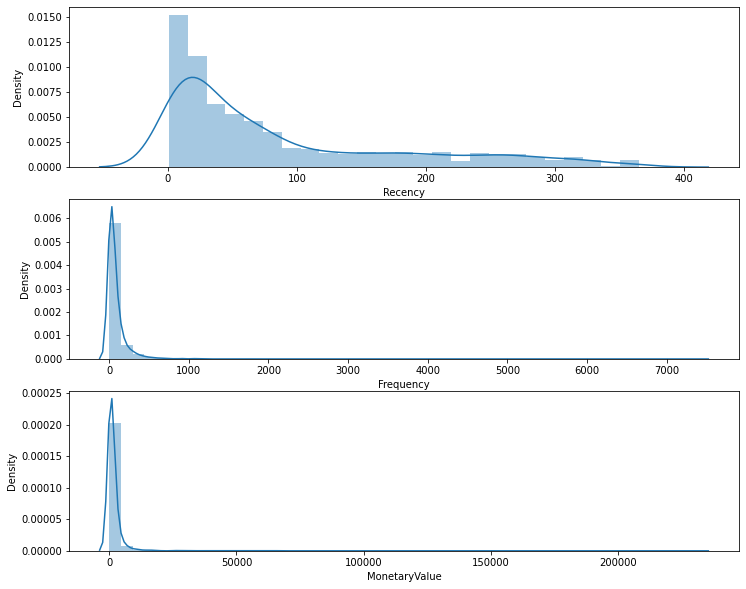

In [160]:
# Checking the distribution of Recency, Frequency and MonetaryValue variables.
plt.figure(figsize=(12,10))

# Plot distribution of var1
plt.subplot(3, 1, 1); sns.distplot(data['Recency'])

# Plot distribution of var2
plt.subplot(3, 1, 2); sns.distplot(data['Frequency'])

# Plot distribution of var3
plt.subplot(3, 1, 3); sns.distplot(data['MonetaryValue'])


As we can see from the above plots, all the variables do not have a symmetrical distribution. All of them are skewed to the right. To remove the skewness, we can try the following transformations:

- log transformations
- Box-Cox transformations
- Cube root transformations

The log transformation cannot be used for negative values. One common practice one can use here is to add a constant value to get a positive value and this is generally taken as the absolute of the least negative value of the variable to each observation. However, in our data, we do not have any negative values since we are dealing with customer transactions dataset.



In [161]:
# Checking for constant mean and variance.
data[['Recency','Frequency','MonetaryValue']].describe()


,Recency,Frequency,MonetaryValue
count,3854.000000,3854.000000,3854.000000
mean,87.546445,86.415931,1763.580214
std,93.486109,206.717466,6652.756855
min,1.000000,1.000000,0.000000
25%,17.000000,16.000000,288.952500
50%,50.000000,39.000000,634.190000
75%,134.000000,95.000000,1534.152500
max,365.000000,7405.000000,231822.690000


From the above description, we can see that the minimum MonetaryValue for a particular customerID is 0. This transaction therefore does not make any sense and needs to be removed.

We also see that we do not get constant mean and standard deviation values.

Removing the customer with 0 MonetaryValue from the data:



In [162]:
data[data['MonetaryValue'] == 0]


,CustomerID,Recency,Frequency,MonetaryValue,R,F,M,RFM_Segment,RFM_Score,General_Segment
310,13256.0,14,1,0.0,4,1,1,4.01.01.0,6,Middle


In [163]:
data = data[data['MonetaryValue'] > 0]
data.reset_index(drop=True,inplace=True)


In [164]:
raw_data = data[['Recency','Frequency','MonetaryValue']]


In [165]:
raw_data.head()

,Recency,Frequency,MonetaryValue
0,326,1,77183.60
1,2,96,3837.45
2,1,4018,30725.81
3,4,197,4045.58
4,3,59,942.34


Let us now apply log transformation to the data and normalize it.



In [166]:
# Unskew the data
data_log = np.log(raw_data)

# Initialize a standard scaler and fit it
scaler = StandardScaler()
scaler.fit(data_log)

# Scale and center the data
data_normalized = scaler.transform(data_log)

# Create a pandas DataFrame
data_norm = pd.DataFrame(data=data_log, index=raw_data.index, columns=raw_data.columns)


In [167]:
data_norm.head()

,Recency,Frequency,MonetaryValue
0,5.786897,0.000000,11.253942
1,0.693147,4.564348,8.252563
2,0.000000,8.298540,10.332858
3,1.386294,5.283204,8.305380
4,1.098612,4.077537,6.848366


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt 

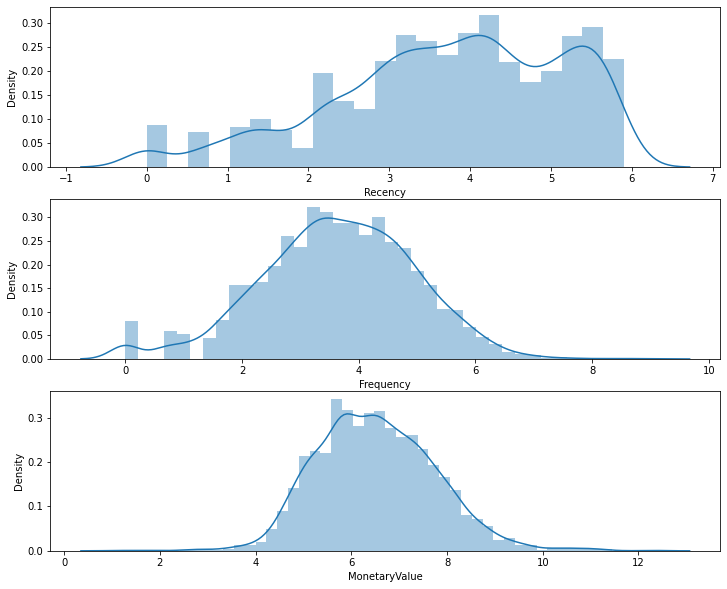

In [ ]:

#Checking for skewness in the data now:

plt.figure(figsize=(12,10))

# Plot recency distribution
plt.subplot(3, 1, 1); sns.distplot(data_norm['Recency'])

# Plot frequency distribution
plt.subplot(3, 1, 2); sns.distplot(data_norm['Frequency'])

# Plot monetary value distribution
plt.subplot(3, 1, 3); sns.distplot(data_norm['MonetaryValue'])

# Show the plot
plt.show()

#As we can see from the above plots, skewness has been removed from the data.



# Clustering with K-means algorithm
In this section, we will build multiple clusters upon our RFM data (data_norm) and will try to find out the optimal number of clusters in our data using the elbow method.



In [168]:
from sklearn.cluster import KMeans


In [169]:
sse = {}

# Fit KMeans and calculate SSE for each k
for k in range(1, 21):
  
    # Initialize KMeans with k clusters
    kmeans = KMeans(n_clusters=k, random_state=1)
    
    # Fit KMeans on the normalized dataset
    kmeans.fit(data_norm)
    
    # Assign sum of squared distances to k element of dictionary
    sse[k] = kmeans.inertia_


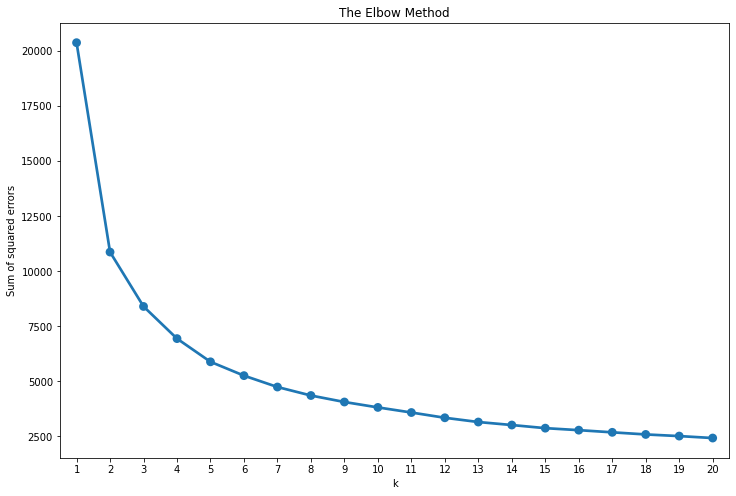

In [171]:
plt.figure(figsize=(12,8))

plt.title('The Elbow Method')
plt.xlabel('k'); 
plt.ylabel('Sum of squared errors')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()


In [172]:
#From the above plot, we can see that the optimal number of cluster is 3 or 4.

#Let us take k = 3 first.

kmeans = KMeans(n_clusters=3, random_state=1)

# Compute k-means clustering on pre-processed data
kmeans.fit(data_norm)

# Extract cluster labels from labels_ attribute
cluster_labels = kmeans.labels_


In [173]:
# Create a cluster label column in the original DataFrame
data_norm_k3 = data_norm.assign(Cluster = cluster_labels)
data_k3 = raw_data.assign(Cluster = cluster_labels)

# Calculate average RFM values and size for each cluster
summary_k3 = data_k3.groupby(['Cluster']).agg({'Recency': 'mean',
                                                    'Frequency': 'mean',
                                                    'MonetaryValue': ['mean', 'count'],}).round(0)

summary_k3


Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         164.0      14.0         282.0  1329
1          11.0     237.0        5180.0   873
2          66.0      65.0        1151.0  1651

In [174]:
#Let us now take k = 4.

kmeans = KMeans(n_clusters=4, random_state=1)

# Compute k-means clustering on pre-processed data
kmeans.fit(data_norm)

# Extract cluster labels from labels_ attribute
cluster_labels = kmeans.labels_


In [175]:
# Create a cluster label column in the original DataFrame
data_norm_k4 = data_norm.assign(Cluster = cluster_labels)
data_k4 = raw_data.assign(Cluster = cluster_labels)

# Calculate average RFM values and size for each cluster
summary_k4 = data_k4.groupby(['Cluster']).agg({'Recency': 'mean',
                                                    'Frequency': 'mean',
                                                    'MonetaryValue': ['mean', 'count'],}).round(0)

summary_k4


Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          10.0     266.0        5932.0   720
1         178.0      15.0         289.0  1218
2          21.0      34.0         521.0   769
3          85.0      85.0        1547.0  1146

Profiling and interpreting segments


In [176]:
display(summary_k3)
display(summary_k4)


Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         164.0      14.0         282.0  1329
1          11.0     237.0        5180.0   873
2          66.0      65.0        1151.0  1651

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          10.0     266.0        5932.0   720
1         178.0      15.0         289.0  1218
2          21.0      34.0         521.0   769
3          85.0      85.0        1547.0  1146

In [177]:
#We can also build snakeplots to understand and compare the segments. Let us build a snakeplot for our data with 4 clusters below.

#Before building snakeplots, let us assign back customerID values to the row indices.


data_norm_k4.index = data['CustomerID'].astype(int)
data_norm_k4.head()


,Recency,Frequency,MonetaryValue,Cluster
CustomerID,,,,
12346,5.786897,0.000000,11.253942,3
12747,0.693147,4.564348,8.252563,0
12748,0.000000,8.298540,10.332858,0
12749,1.386294,5.283204,8.305380,0
12820,1.098612,4.077537,6.848366,0


In [178]:
# Melt the data into along format so RFM values and metric names are stored in 1 column each
data_melt = pd.melt(data_norm_k4.reset_index(),
                    id_vars=['CustomerID', 'Cluster'],
                    value_vars=['Recency', 'Frequency', 'MonetaryValue'],
                    var_name='Attribute',
                    value_name='Value')


<AxesSubplot:title={'center':'Snake plot of standardized variables'}, xlabel='Attribute', ylabel='Value'>

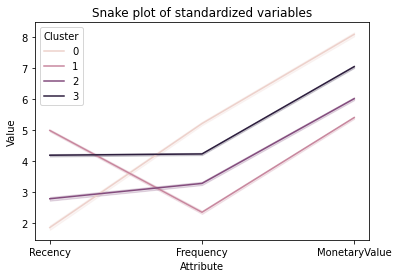

In [179]:
plt.title('Snake plot of standardized variables')
sns.lineplot(x="Attribute", y="Value", hue='Cluster', data=data_melt)



In [180]:
#We can also use the following method to understand the relative importance of segments in the data. To do this, we will complete the following steps: 1. Calculate average values of each cluster 2. Calculate average values of population 3. Calculate importance score by dividing them and subtracting 1 (ensures 0 is returned when cluster average equals population average)
#Assigning CustomerID index to data_k4 dataframe:


data_k4.index = data['CustomerID'].astype(int)
data_k4.head()


,Recency,Frequency,MonetaryValue,Cluster
CustomerID,,,,
12346,326,1,77183.60,3
12747,2,96,3837.45,0
12748,1,4018,30725.81,0
12749,4,197,4045.58,0
12820,3,59,942.34,0


<AxesSubplot:title={'center':'Snake plot of standardized variables'}, xlabel='Attribute', ylabel='Value'>

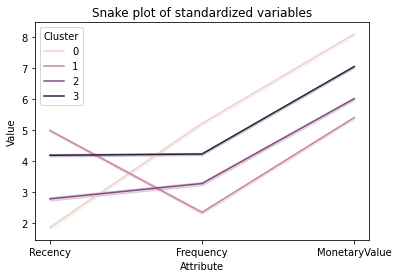

In [181]:
# Melt the data into along format so RFM values and metric names are stored in 1 column each
data_melt = pd.melt(data_norm_k4.reset_index(),
                    id_vars=['CustomerID', 'Cluster'],
                    value_vars=['Recency', 'Frequency', 'MonetaryValue'],
                    var_name='Attribute',
                    value_name='Value')


plt.title('Snake plot of standardized variables')
sns.lineplot(x="Attribute", y="Value", hue='Cluster', data=data_melt)


In [182]:
#We can also use the following method to understand the relative importance of segments in the data. To do this, we will complete the following steps: 1. Calculate average values of each cluster 2. Calculate average values of population 3. Calculate importance score by dividing them and subtracting 1 (ensures 0 is returned when cluster average equals population average)

#Assigning CustomerID index to data_k4 dataframe:

data_k4.index = data['CustomerID'].astype(int)
data_k4.head()



,Recency,Frequency,MonetaryValue,Cluster
CustomerID,,,,
12346,326,1,77183.60,3
12747,2,96,3837.45,0
12748,1,4018,30725.81,0
12749,4,197,4045.58,0
12820,3,59,942.34,0


In [183]:
#Assigning CustomerID index to raw_data dataframe:

raw_data.index = data['CustomerID'].astype(int)
raw_data.head()



,Recency,Frequency,MonetaryValue
CustomerID,,,
12346,326,1,77183.60
12747,2,96,3837.45
12748,1,4018,30725.81
12749,4,197,4045.58
12820,3,59,942.34


In [184]:
cluster_avg = data_k4.groupby(['Cluster']).mean()
population_avg = raw_data.head().mean()


In [185]:
cluster_avg


,Recency,Frequency,MonetaryValue
Cluster,,,
0,9.748611,266.102778,5932.222083
1,177.951560,14.690476,289.131298
2,21.401821,34.361508,520.673615
3,84.788831,84.760035,1547.188755


In [186]:
population_avg


Recency             67.200
Frequency          874.200
MonetaryValue    23346.956
dtype: float64

In [187]:
relative_imp = cluster_avg / population_avg - 1
relative_imp.round(2)


,Recency,Frequency,MonetaryValue
Cluster,,,
0,-0.85,-0.70,-0.75
1,1.65,-0.98,-0.99
2,-0.68,-0.96,-0.98
3,0.26,-0.90,-0.93


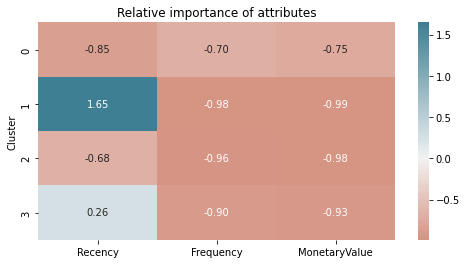

In [189]:
# Plot heatmap
plt.figure(figsize=(8, 4))
plt.title('Relative importance of attributes')
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap=sns.diverging_palette(20, 220, n=200), center=0)
plt.show()



